# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Зайдель".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

$$L(w) = \frac{1}{N}\sum_i \log(1 + e^{-y^{(i)} <w,x^{(i)}>}) + \frac{1}{C}\sum_{j=1}^{m} w_j^2 \rightarrow \min_w$$

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.
$$L(w) = \frac{-1}{N}\sum_i \log( \sigma(y^{(i)} <w,x^{(i)}>)) + \frac{1}{C}\sum_{j=1}^{m} w_j^2 \rightarrow \min_w$$
$$ \frac{\partial L}{\partial w_k} =  -\frac{1}{N} \sum_i  y^{(i)} x^{(i)}_k \sigma(-y^{(i)} <w,x^{(i)}>)   + \frac{2}{C}  w_k$$

$$ w_{n+1} = w_{n} - \eta_{n} \frac{\partial L}{\partial w} (w_n) $$

$$ w_{n+1} = w_{n} + \eta_{n} \frac{1}{N} \sum_i  y^{(i)} x^{(i)} \sigma(-y^{(i)} <w_{n},x^{(i)}>)   - \eta_{n}     \frac{2}{C} w $$

$$\eta_n = \frac{alpha}{n}$$

## Имплементация (5 баллов)

In [70]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, verbose = False, nbatch = 10, seed = None):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.verbose = verbose
        self.seed = seed
        self.nbatch = nbatch
        
    
    def fit(self, X_train, y_train=None):
        '''
        Обучение модели
        '''
        np.random.seed(self.seed)
        y = np.copy(y_train)
        X = np.copy(X_train)
        
        y_uniq = np.unique(y)
        
        if y_uniq.shape[0] > 2:
            raise "multiclass not implemented!"
        y[y == y_uniq[0]] = -1
        y[y == y_uniq[1]] = 1
        
           
        X = np.c_[X_train, np.ones(X.shape[0])]
          
        X_dim = X.shape[1]
        X_size = X.shape[0]
        
        self.minibatch_size =  X_size / self.nbatch
        
        model = np.random.uniform(low= -2.0/(X_dim), high=2.0/(X_dim), size=(X_dim,))
        
        eta = 1.0
        
        self.errors = []
        
        for epoch in xrange(1,self.max_epoch):
            
            eta = self.alpha/epoch
            shuffeled_indexes = np.random.permutation(np.arange(X_size))
            shuffeled_indexes = np.array_split(shuffeled_indexes, self.minibatch_size)

            for batch_indexes in shuffeled_indexes:
                
                X_batch = X[batch_indexes]
                y_batch = y[batch_indexes]

                batch_size = X_batch.shape[0]
                
                buffer_array = np.sum( y_batch[:, np.newaxis] * 
                                      self.__sigm( - y_batch * X_batch.dot( model ) )[:, np.newaxis] * X_batch, 
                                      axis = 0)
                
                buf_model = np.copy(model)
                buf_model[-1] = 0
                model += (( - 2.0 * eta/self.C ) * buf_model +  ((eta)/batch_size) * buffer_array )
            
            error = (-1.0/ X_size) * np.sum( np.log( self.__sigm(y * X.dot(model)) ) , axis = 0)  + 1.0/self.C * np.sum(model**2)
            self.errors.append(error)
            
            if self.verbose == True: 
                print "epoch: {0} , eta: {1} , error: {2}".format(epoch, eta, error)
                print "  model: {0}".format(model)
                                
        self.model = model
        return self
    
    def __sigm(self, z):
        return 1.0/(1.0 + np.exp(-z))
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X_with_constant_column = np.c_[X, np.ones(X.shape[0])]
        y_hat = np.sign(X_with_constant_column.dot(self.model))
        
        # классификация 0 и 1 вместо -1 и 1
        y_hat[y_hat == -1] = 0
             
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X_with_constant_column = np.c_[X, np.ones(X.shape[0])]
        y_prob = self.__sigm(X_with_constant_column.dot(self.model))
        return y_prob

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

400


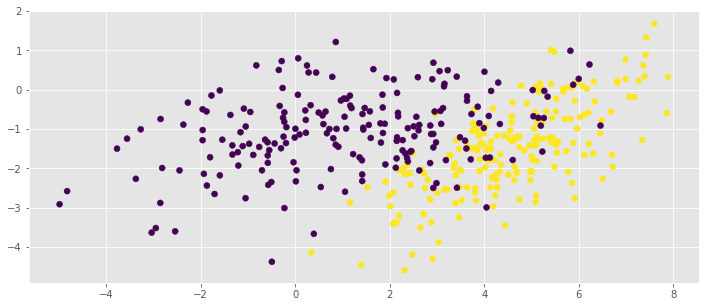

In [71]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

print X.shape[0]

plt.scatter(X[:,0], X[:,1], c=y)

0.8375
[ 0.24253927 -0.06538447 -0.77979943]


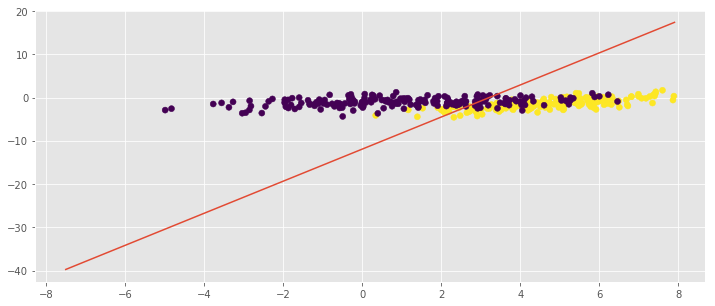

In [75]:
model = MySGDClassifier(max_epoch=1000, C = 1.0, alpha= 0.5, nbatch=8)
model.fit(X, y)

y_pred = model.predict(X)
plt.scatter(X[:,0], X[:,1], c=y)

x_plt = np.arange(-7.5,8.0, 0.1)
w = model.model
y_plt = (-w[2]-w[0]*x_plt)/w[1]
plt.plot(x_plt,y_plt)

print roc_auc_score(y, y_pred)
print w

In [ ]:
# Cs = np.linspace(start=0.1, stop=10, num = 10)
# alphas = np.linspace(start=0.0001, stop=1.0, num = 10)
# results = np.zeros((Cs.shape[0], alphas.shape[0]))

# for i in range(Cs.shape[0]):
#     for j in range(alphas.shape[0]):
#         model = MySGDClassifier(max_epoch=1000, C = Cs[i], alpha=alphas[i], minibatch_size=50, seed = 123)
#         model.fit(X, y)

#         y_pred = model.predict(X)
#         results[i,j] = roc_auc_score(y, y_pred)

# print results
# print np.argmax(results)

0.655


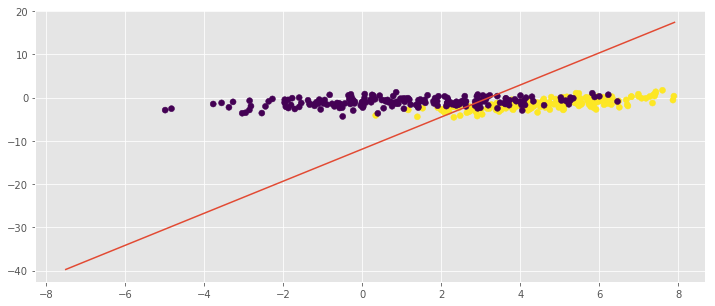

In [74]:
from sklearn.linear_model import SGDClassifier

sk_model = SGDClassifier(loss = 'log', penalty='l2', alpha= 1/5, max_iter=1000, tol = None, 
                      learning_rate='invscaling', eta0 = 0.01 , power_t = 1.0, random_state = 12)
sk_model.fit(X, y)
sk_y_pred = sk_model.predict(X)

plt.scatter(X[:,0], X[:,1], c=y)

x_plt = np.arange(-7.5,8.0, 0.1)

sk_w = sk_model.coef_[0]
sk_w = np.append(w,sk_model.intercept_)
sk_y_plt = (-sk_w[2] - sk_w[0]*x_plt)/sk_w[1]

plt.plot(x_plt,sk_y_plt)

print roc_auc_score(y, sk_y_pred)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [76]:
from sklearn.datasets import make_classification

In [77]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

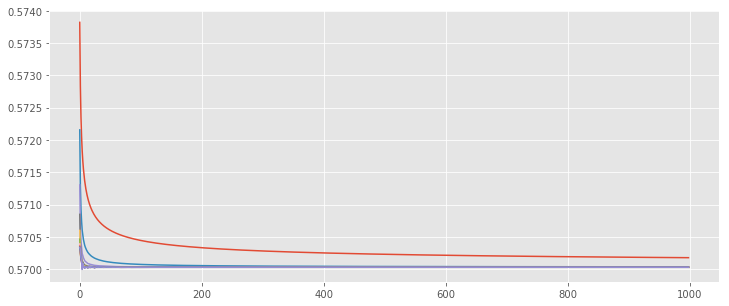

In [87]:
## Your Code Here
from tqdm import tqdm_notebook

alphas = np.linspace(start=0.01, stop=0.1, num = 10)
results = []
for a in tqdm_notebook(alphas):
    model = MySGDClassifier(max_epoch=1000, C = 1.0 , alpha= a, nbatch=500, seed = 0)
    model.fit(X, y)
    results.append(model.errors)


for y_plt in results:
    x_plt = np.arange(len(y_plt))
    plt.plot(x_plt,y_plt)


## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: overflow encountered in exp
/home/peter/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in multiply


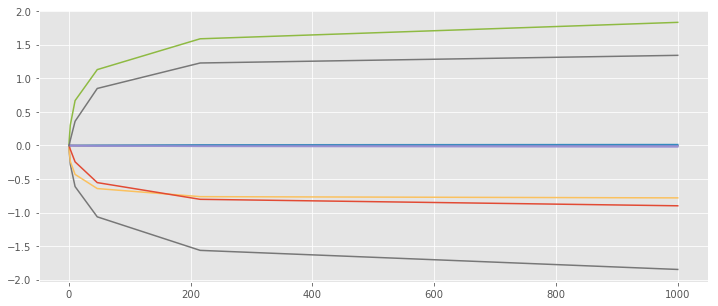

In [95]:
## Your Code Here
Cs = np.logspace(3, -3, 10)
weights = np.empty(shape = (Cs.shape[0], X.shape[1]+1))
idx = 0
for c in tqdm_notebook(Cs):
    
    model = MySGDClassifier(max_epoch=1000, C = c, alpha=0.01, nbatch=100)
    model.fit(X, y)

    y_pred = model.predict(X)
    weights[idx] = np.array(model.model)
    idx+=1

plt_x = Cs
plt_y = weights.transpose()

for i in range(plt_y.shape[0]):
    plt.plot(plt_x,plt_y[i])

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [38]:
# Загрузка одной части данных

df_data = pd.read_csv('/home/peter/Документы/Data/hw4_algo_data/trainingData_tabular_chunk1.csv', sep=',')
df_test_data = pd.read_csv('/home/peter/Документы/Data/hw4_algo_data/testData_tabular_chunk5.csv', sep = ',')

df_test_labels = pd.read_csv('/home/peter/Документы/Data/hw4_algo_data/deprecated_testLabels.txt', names = ['decision'])
df_test_labels = df_test_labels.loc[:df_test_data.shape[0]-1]

# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.drop('gamestate_id', axis = 1 )

df_test_data.decision = df_test_labels.decision


In [39]:
# # Загрузка данных целиком
# df_list = []
# for chunk in range(1,2):#in range(1,5):
#     filepath = '/home/peter/Документы/Data/hw4_algo_data/trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)


# df_test_list = []
# for chunk in range(5,6): #in range(5,8):
#     filepath = '/home/peter/Документы/Data/hw4_algo_data/testData_tabular_chunk%d.csv' % chunk
#     df_test_list.append(pd.read_csv(filepath, sep=','))
# df_test_data = pd.concat(df_test_list)

# df_test_labels = pd.read_csv('/home/peter/Документы/Data/hw4_algo_data/deprecated_testLabels.txt', names = ['decision'])
# df_test_labels = df_test_labels.loc[:df_test_data.shape[0]-1]


# print df_test_data.shape
# print df_test_labels.shape

# # Загрузка одной части данных
# # filepath = './trainingData_tabular_chunk1.csv'
# # df_data = pd.read_csv(filepath, sep=',')

# # для удобства
# df_data.columns = df_data.columns.str.replace('.', '_')
# df_data = df_data.set_index('gamestate_id')

# df_test_data.columns = df_test_data.columns.str.replace('.', '_')
# df_test_data = df_test_data.drop('gamestate_id', axis = 1 )

# df_test_data.decision = df_test_labels.decision

In [40]:
df_data

,decision,turn,opponent_armor,opponent_attack,opponent_hero_card_id,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,...,player_played_hp_current,player_played_hp_max,player_hand_nOfMinions,player_hand_nOfSpells,player_hand_nOfWeapons,player_hand_nOfCards,player_hand_nOfPlayable,player_hand_attack,player_hand_crystals_cost,player_hand_hp
gamestate_id,,,,,,,,,,,,,,,,,,,,,
4687346,1,14,0,0,798,5,0,0,10,10,...,20,23,4,0,1,5,0,20,22,17
3270826,1,7,0,0,754,22,0,0,6,6,...,16,17,3,2,2,7,0,17,26,20
3189487,1,5,3,0,612,29,0,0,4,1,...,0,0,5,0,0,5,2,26,28,27
4098946,1,8,0,0,390,26,0,0,7,7,...,2,2,7,1,1,9,9,36,44,36
2661127,0,13,0,0,25,30,0,0,10,1,...,7,7,4,0,0,4,4,13,13,14
2993360,0,13,0,0,612,26,0,0,10,3,...,9,9,5,0,0,5,0,19,25,25
4378268,0,9,0,0,612,20,0,0,9,2,...,8,8,5,1,0,6,6,23,30,23
3774658,1,2,0,0,390,30,0,0,1,1,...,0,0,4,1,0,5,1,22,25,25
3956442,1,12,2,0,1235,18,0,0,10,2,...,2,6,2,1,1,4,4,12,15,10


In [41]:
df_test_data

,decision,turn,opponent_armor,opponent_attack,opponent_hero_card_id,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,...,player_played_hp_current,player_played_hp_max,player_hand_nOfMinions,player_hand_nOfSpells,player_hand_nOfWeapons,player_hand_nOfCards,player_hand_nOfPlayable,player_hand_attack,player_hand_crystals_cost,player_hand_hp
0,1,5,0,0,981,23,0,0,4,0,...,5,5,2,1,0,3,1,6,11,9
1,1,9,0,3,754,16,0,1,8,3,...,9,12,3,1,0,4,4,13,14,13
2,1,16,0,0,798,16,1,0,10,2,...,20,29,0,1,0,1,0,0,5,0
3,1,3,0,0,326,30,0,0,2,2,...,0,0,3,1,0,4,0,12,12,11
4,0,5,0,0,25,30,0,0,4,1,...,1,3,2,2,0,4,0,8,15,9
5,1,12,0,0,798,15,0,0,10,3,...,17,17,1,2,0,3,2,6,11,6
6,0,10,4,0,612,24,0,0,10,0,...,2,11,6,0,0,6,0,16,21,24
7,0,10,0,1,754,19,1,2,9,7,...,0,0,4,1,0,5,0,22,31,25
8,0,7,0,0,494,24,0,0,6,0,...,4,4,2,2,1,5,5,12,21,16
9,1,5,0,0,612,24,0,0,5,1,...,10,10,4,1,0,5,0,19,23,20


In [42]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [ ]:
# Youd Code Here
print "hero unique cards number: ", df_data.player_hero_card_id.unique().shape[0]
print "opponent unique cards number: ", df_data.opponent_hero_card_id.unique().shape[0]

In [43]:
def prepare_data(df):
    columns = df.columns.values
    columns = columns[columns != 'decision']

    cat_cols = [] #['opponent_hero_card_id', 'player_hero_card_id']
    for cl in columns:
        if (cl.find("id") > 0 ):
            cat_cols.append(cl)
        
    print "категориальные признаки:", cat_cols
    for cl in cat_cols:
        print cl,": ", df[cl].unique()
        
    for cl in cat_cols:
        df = df.join(pd.get_dummies(df[cl], prefix=cl))
        
    df = df.drop(cat_cols, axis = 1)
    return df

In [44]:
df_data = prepare_data(df_data)
df_data.head().T

категориальные признаки: ['opponent_hero_card_id', 'player_hero_card_id']
opponent_hero_card_id :  [ 798  754  612  390   25 1235  494  981  326]
player_hero_card_id :  [ 981  754  612  494   25 1235  326  390  798]


gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


In [45]:
df_test_data = prepare_data(df_test_data)
df_test_data.head().T

категориальные признаки: ['opponent_hero_card_id', 'player_hero_card_id']
opponent_hero_card_id :  [ 981  754  798  326   25  612  494  390 1235]
player_hero_card_id :  [ 612  798   25  754  326  494 1235  981  390]


,0,1,2,3,4
decision,1,1,1,1,0
turn,5,9,16,3,5
opponent_armor,0,0,0,0,0
opponent_attack,0,3,0,0,0
opponent_hp,23,16,16,30,30
opponent_special_skill_used,0,0,1,0,0
opponent_weapon_durability,0,1,0,0,0
opponent_crystals_all,4,8,10,2,4
opponent_crystals_current,0,3,2,2,1
opponent_deck_count,21,17,9,24,22


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [53]:
## Youd Code Here

X = df_data.loc[:, df_data.columns != 'decision'].values
y = df_data['decision'].values

In [54]:
print X.shape, y.shape

(500000, 59) (500000,)


In [59]:
train_indexes = np.random.permutation(np.arange(X.shape[0]))
train_indexes = train_indexes[:10000]

X_train = X[train_indexes]
y_train = y[train_indexes]

X_test = df_test_data.loc[:, df_test_data.columns != 'decision'].values
y_test = df_test_data['decision'].values

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
estimator = MySGDClassifier()
pipe = Pipeline(steps = [('std_scaler', scaler), ('clf', estimator)])

In [61]:
from sklearn.model_selection import GridSearchCV
params = {'clf__alpha': (0.01, 0.001, 0.0001), 'clf__max_epoch': (500,  1000), 'clf__C': (0.1, 1, 10), 'clf__nbatch': (16, 100)}
grid = GridSearchCV(pipe, params, verbose = 1).fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66
416
416
416
66
66
66


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 13.1min finished


625


In [62]:
print grid.best_estimator_
print grid.best_score_
grid.best_params_

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', MySGDClassifier(C=10, alpha=0.01, max_epoch=500, minibatch_size=625,
        nbatch=16, seed=None, verbose=False))])
0.6874


{'clf__C': 10, 'clf__alpha': 0.01, 'clf__max_epoch': 500, 'clf__nbatch': 16}

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [63]:
from sklearn.metrics import roc_auc_score
model = grid.best_estimator_
my_y = model.predict(X_test)
roc_auc_score(y_test, my_y)

0.69079362526999932

In [66]:
# Для сравнения sklearn с аналогичными параметрами
from sklearn.linear_model import SGDClassifier

scaler = StandardScaler()
sk_estimator = SGDClassifier(loss = 'log', penalty='l2', alpha= 1/10, max_iter=500, tol = None, 
                      learning_rate='invscaling', eta0 = 0.01 , power_t = 1.0, random_state = 12)
sk_model = Pipeline(steps = [('std_scaler', scaler), ('clf', sk_estimator)])

sk_model.fit(X_train, y_train)

roc_auc_score(y_test, sk_model.predict(X_test))

0.65521728920722433